In [1]:
import os

path = os.path.join(os.path.dirname(os.getcwd()), "data")
msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")

In [2]:
from matchms.filtering import normalize_intensities
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import require_minimum_number_of_peaks
import random

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    return s

def group_by_inchikey(spectrums):
    grouped_spectrum = []
    inchikeys = []
    for s in spectrums:
        inchikey = s.metadata.get('inchikey').split('-', 1)[0]
        if inchikey not in inchikeys:
            inchikeys.append(inchikey)
            grouped_spectrum.append([s]) 
        else:
            index = inchikeys.index(inchikey)
            grouped_spectrum[index].append(s)
    return grouped_spectrum

def separate_by_same_inchikey(spectrums):
    return random.sample([k for k in group_by_inchikey(spectrums) if len(k) == 2], 1000)

def separate_by_diff_inchikey(spectrums):
    # grouped_spectrum = group_by_inchikey(spectrums)
    # shuffled1 = random.sample(grouped_spectrum, len(grouped_spectrum))
    # shuffled2 = random.sample(grouped_spectrum, len(grouped_spectrum))
    # selectec_spectra = []
    # for n in range(0, 1000):
    #     selectec_spectra.append([shuffled1[n][0], shuffled2[n][0]])
    # return selectec_spectra

    selected_spectrum = [[g[0]] for g in spectrums]
        
    for k, e in enumerate(selected_spectrum):
        diff_mol = random.sample(spectrums, 1)
        while e[0].metadata['inchikey'].split(',', 1)[0] == diff_mol[0][1].metadata['inchikey'].split(',', 1)[0]:
            diff_mol = random.sample(spectrums, 1)
        selected_spectrum[k].append(diff_mol[0][1])

    return selected_spectrum

In [3]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
import numpy as np

def calculate_similarity_scores(group_spectra):
    scores_hist = []
    for k, spectrums in enumerate(group_spectra):
        scores = calculate_scores(references=spectrums,
                                queries=spectrums,
                                similarity_function=CosineGreedy())

        # print(k+1, "================================")
        for k, score in enumerate(scores):
            if k == 1:
                (reference, query, score, n_matching) = score

                scores_hist.append(score)

                # print(f"Reference scan name: {reference.metadata['name']} - Query scan name: {query.metadata['name']}")
                # print(f"Reference InChiKey: {reference.metadata['inchikey']} - Query InChiKey: {query.metadata['inchikey']}")
                # print(f"Score: {score:.4f}")
                # print(f"Number of matching peaks: {n_matching}")
                # print("----------------------------")

    return np.array(scores_hist)

In [4]:
from matchms.importing import load_from_msp

def get_gcms_data():
    spectrums = [apply_my_filters(s) for s in load_from_msp(msp_file)]

    return [s for s in spectrums if s is not None]

def get_grouped_spectra(spectra):
    group_spectra = separate_by_same_inchikey(spectra)
    group_spectra2 = separate_by_diff_inchikey(group_spectra)

    return [
       {
            "data": group_spectra,
            "scores": calculate_similarity_scores(group_spectra)
        },
        {
            "data": group_spectra2,
            "scores": calculate_similarity_scores(group_spectra2)
        },
    ]

In [5]:
import matplotlib.pyplot as plt

def print_histogram(data):
    plt.figure(figsize=(12,7))
    hist = plt.hist(data)
    plt.xlabel("Scores")
    plt.ylabel("Number of pairs Spectra")
    plt.show()
    
def plot_mirror_histogram(data1, data2, start, end):
    number_of_scores = np.arange(1, len(data1)+1)
    x_lims = [-0.05, 1.05]

    plt.figure(figsize=(12,7))
    ax1 = plt.subplot(211)
    plt.subplots_adjust(hspace=0.0)
    plt.hist(data1[start:end])
    ax1.set_ylim(0, len(data1))
    ax1.set_xlim(x_lims)

    ax2 = plt.subplot(212)
    plt.hist(data2[start:end], color='#f9ad37')
    ax2.set_ylim(len(data2),0)
    ax2.set_xlim(x_lims)
    plt.show()

In [6]:
def show_data(spectra, title):
    group_spectra = get_grouped_spectra(spectra)
    print(title)
    plot_mirror_histogram(group_spectra[0]['scores'], group_spectra[1]['scores'], 0, 1000)
    print_histogram(group_spectra[0]['scores'])
    print_histogram(group_spectra[1]['scores'])

In [7]:
spectra = get_gcms_data()

Example 1


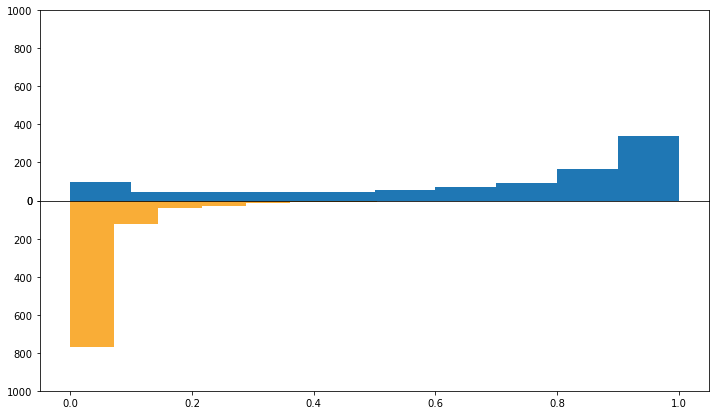

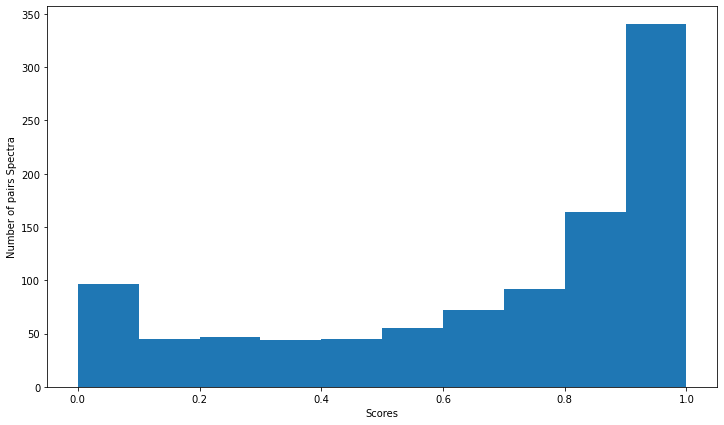

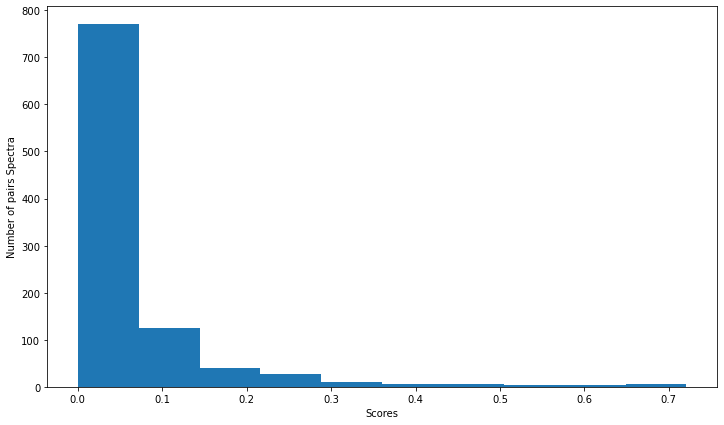

In [8]:
show_data(spectra.copy(), "Example 1")

Example 2


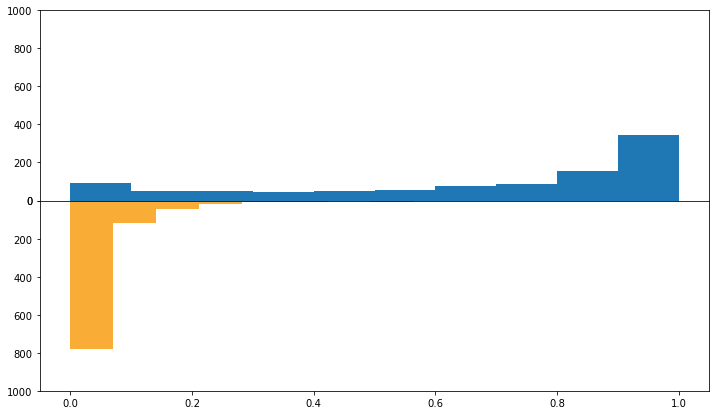

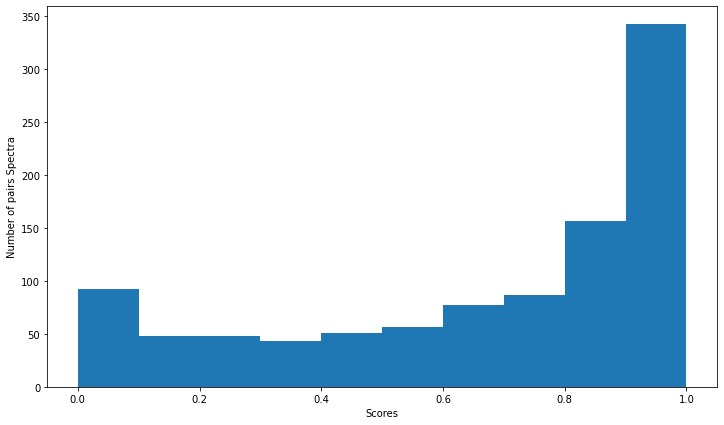

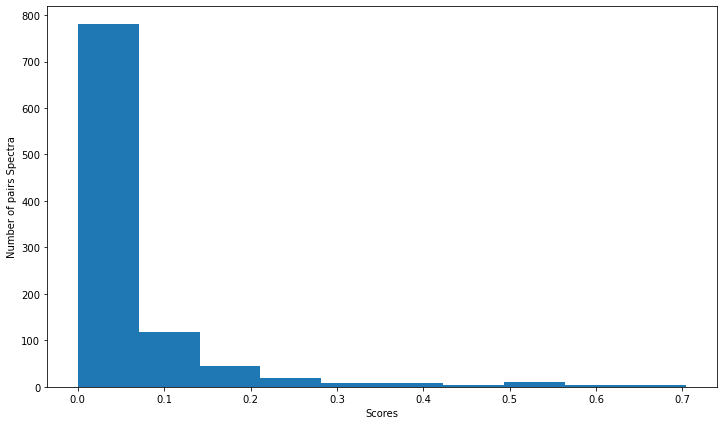

In [9]:
show_data(spectra.copy(), "Example 2")

Example 3


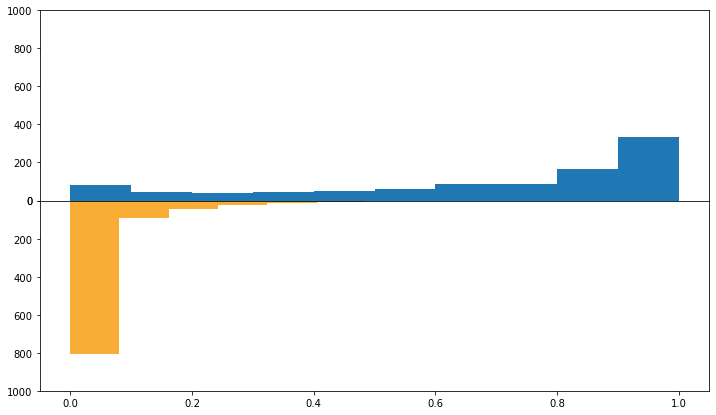

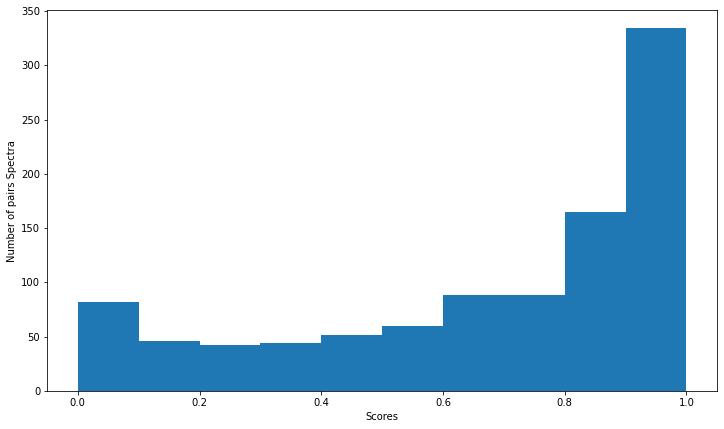

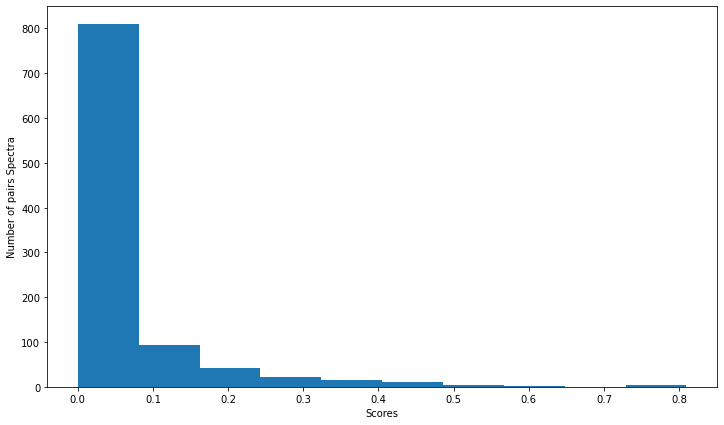

In [10]:
show_data(spectra.copy(), "Example 3")

Example 4


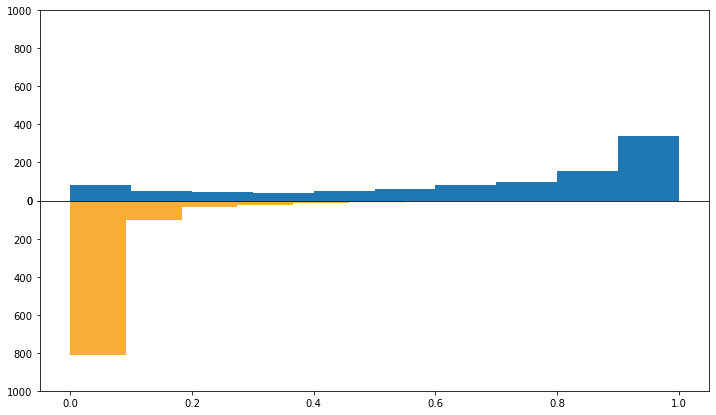

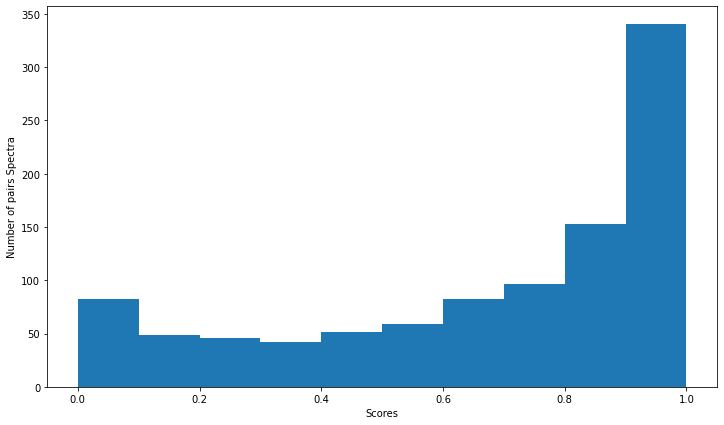

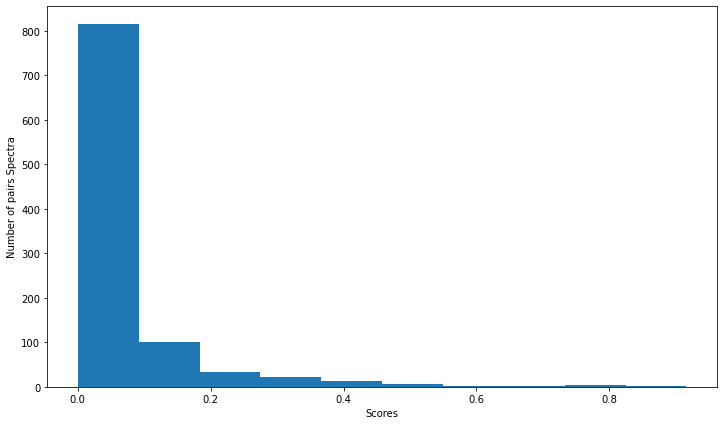

In [11]:
show_data(spectra.copy(), "Example 4")